In [5]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib
import warnings

In [ ]:
e_list = [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30] 
# Lista de parâmetros n para iterar
e_list = range(16, 50, 1)

In [6]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')

# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]

# Parâmetros adicionais
n = 14
d = 90
t = 14
e_list = range(150, 300, 1)
alpha = 0.06  # Mantemos um único valor de alpha

# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)




price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)


price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target_verify(x, d)
)

# Loop para calcular e salvar a variável para cada valor de 'e'
for e in e_list:
    # Calcula o Price Rate of Change para o valor atual de 'e'
    price_data[f'Price_Rate_Of_Change_{e}'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
        lambda x: x.pct_change(periods=e)
    )

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)


price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)


# Criação das variáveis low_t e high_t
low_t, high_t = price_data[['Ticker', 'Low']].copy(), price_data[['Ticker', 'High']].copy()
# Cálculo dos valores mínimos e máximos baseados na janela t
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=t).max())

# Cálculo do k_percent
k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))


# Armazenando os resultados no DataFrame com nomes dinâmicos
price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent


# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)
price_data[f'r_percent_{t}'] = r_percent


# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)


# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()
warnings.filterwarnings("ignore")
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Price_Rate_Of_Change_150,Price_Rate_Of_Change_151,Price_Rate_Of_Change_152,Price_Rate_Of_Change_153,Price_Rate_Of_Change_154,Price_Rate_Of_Change_155,Price_Rate_Of_Change_156,Price_Rate_Of_Change_157,Price_Rate_Of_Change_158,Price_Rate_Of_Change_159,Price_Rate_Of_Change_160,Price_Rate_Of_Change_161,Price_Rate_Of_Change_162,Price_Rate_Of_Change_163,Price_Rate_Of_Change_164,Price_Rate_Of_Change_165,Price_Rate_Of_Change_166,Price_Rate_Of_Change_167,Price_Rate_Of_Change_168,Price_Rate_Of_Change_169,Price_Rate_Of_Change_170,Price_Rate_Of_Change_171,Price_Rate_Of_Change_172,Price_Rate_Of_Change_173,Price_Rate_Of_Change_174,Price_Rate_Of_Change_175,Price_Rate_Of_Change_176,Price_Rate_Of_Change_177,Price_Rate_Of_Change_178,Price_Rate_Of_Change_179,Price_Rate_Of_Change_180,Price_Rate_Of_Change_181,Price_Rate_Of_Change_182,Price_Rate_Of_Change_183,Price_Rate_Of_Change_184,Price_Rate_Of_Change_185,Price_Rate_Of_Change_186,Price_Rate_Of_Change_187,Price_Rate_Of_Change_188,Price_Rate_Of_Change_189,Price_Rate_Of_Change_190,Price_Rate_Of_Change_191,Price_Rate_Of_Change_192,Price_Rate_Of_Change_193,Price_Rate_Of_Change_194,Price_Rate_Of_Change_195,Price_Rate_Of_Change_196,Price_Rate_Of_Change_197,Price_Rate_Of_Change_198,Price_Rate_Of_Change_199,Price_Rate_Of_Change_200,Price_Rate_Of_Change_201,Price_Rate_Of_Change_202,Price_Rate_Of_Change_203,Price_Rate_Of_Change_204,Price_Rate_Of_Change_205,Price_Rate_Of_Change_206,Price_Rate_Of_Change_207,Price_Rate_Of_Change_208,Price_Rate_Of_Change_209,Price_Rate_Of_Change_210,Price_Rate_Of_Change_211,Price_Rate_Of_Change_212,Price_Rate_Of_Change_213,Price_Rate_Of_Change_214,Price_Rate_Of_Change_215,Price_Rate_Of_Change_216,Price_Rate_Of_Change_217,Price_Rate_Of_Change_218,Price_Rate_Of_Change_219,Price_Rate_Of_Change_220,Price_Rate_Of_Change_221,Price_Rate_Of_Change_222,Price_Rate_Of_Change_223,Price_Rate_Of_Change_224,Price_Rate_Of_Change_225,Price_Rate_Of_Change_226,Price_Rate_Of_Change_227,Price_Rate_Of_Change_228,Price_Rate_Of_Change_229,Price_Rate_Of_Change_230,Price_Rate_Of_Change_231,Price_Rate_Of_Change_232,Price_Rate_Of_Change_233,Price_Rate_Of_Change_234,Price_Rate_Of_Change_235,Price_Rate_Of_Change_236,Price_Rate_Of_Change_237,Price_Rate_Of_Change_238,Price_Rate_Of_Change_239,Price_Rate_Of_Change_240,Price_Rate_Of_Change_241,Price_Rate_Of_Change_242,Price_Rate_Of_Change_243,Price_Rate_Of_Change_244,Price_Rate_Of_Change_245,Price_Rate_Of_Change_246,Price_Rate_Of_Change_247,Price_Rate_Of_Change_248,Price_Rate_Of_Change_249,Price_Rate_Of_Change_250,Price_Rate_Of_Change_251,Price_Rate_Of_Change_252,Price_Rate_Of_Change_253,Price_Rate_Of_Change_254,Price_Rate_Of_Change_255,Price_Rate_Of_Change_256,Price_Rate_Of_Change_257,Price_Rate_Of_Change_258,Price_Rate_Of_Change_259,Price_Rate_Of_Change_260,Price_Rate_Of_Change_261,Price_Rate_Of_Change_262,Price_Rate_Of_Change_263,Price_Rate_Of_Change_264,Price_Rate_Of_Change_265,Price_Rate_Of_Change_266,Price_Rate_Of_Change_267,Price_Rate_Of_Change_268,Price_Rate_Of_Change_269,Price_Rate_Of_Change_270,Price_Rate_Of_Change_271,Price_Rate_Of_Change_272,Price_Rate_Of_Change_273,Price_Rate_Of_Change_274,Price_Rate_Of_Change_275,Price_Rate_Of_Change_276,Price_Rate_Of_Change_277,Price_Rate_Of_Change_278,Price_Rate_Of_Change_279,Price_Rate_Of_Change_280,Price_Rate_Of_Change_281,Price_Rate_Of_Change_282,Price_Rate_Of_Change_283,Price_Rate_Of_Change_284,Price_Rate_Of_Change_285,Price_Rate_Of_Change_286,Price_Rate_Of_Change_287,Price_Rate_Of_Change_288,Price_Rate_Of_Change_289,Price_Rate_Of_Change_290,Price_Rate_Of_Change_291,Price_Rate_Of_Change_292,Price_Rate_Of_Change_293,Price_Rate_Of_Change_294,Price_Rate_Of_Change_295,Price_Rate_Of_Change_296,Price_Rate_Of_Change_297,Price_Rate_Of_Change_298,Price_Rate_Of_Change_299,down_days,up_days,RSI,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,On Balance Volume,Close_10
11689,2024-09-09,57.110001,57.

In [7]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Price_Rate_Of_Change_150,Price_Rate_Of_Change_151,Price_Rate_Of_Change_152,Price_Rate_Of_Change_153,Price_Rate_Of_Change_154,Price_Rate_Of_Change_155,Price_Rate_Of_Change_156,Price_Rate_Of_Change_157,Price_Rate_Of_Change_158,Price_Rate_Of_Change_159,Price_Rate_Of_Change_160,Price_Rate_Of_Change_161,Price_Rate_Of_Change_162,Price_Rate_Of_Change_163,Price_Rate_Of_Change_164,Price_Rate_Of_Change_165,Price_Rate_Of_Change_166,Price_Rate_Of_Change_167,Price_Rate_Of_Change_168,Price_Rate_Of_Change_169,Price_Rate_Of_Change_170,Price_Rate_Of_Change_171,Price_Rate_Of_Change_172,Price_Rate_Of_Change_173,Price_Rate_Of_Change_174,Price_Rate_Of_Change_175,Price_Rate_Of_Change_176,Price_Rate_Of_Change_177,Price_Rate_Of_Change_178,Price_Rate_Of_Change_179,Price_Rate_Of_Change_180,Price_Rate_Of_Change_181,Price_Rate_Of_Change_182,Price_Rate_Of_Change_183,Price_Rate_Of_Change_184,Price_Rate_Of_Change_185,Price_Rate_Of_Change_186,Price_Rate_Of_Change_187,Price_Rate_Of_Change_188,Price_Rate_Of_Change_189,Price_Rate_Of_Change_190,Price_Rate_Of_Change_191,Price_Rate_Of_Change_192,Price_Rate_Of_Change_193,Price_Rate_Of_Change_194,Price_Rate_Of_Change_195,Price_Rate_Of_Change_196,Price_Rate_Of_Change_197,Price_Rate_Of_Change_198,Price_Rate_Of_Change_199,Price_Rate_Of_Change_200,Price_Rate_Of_Change_201,Price_Rate_Of_Change_202,Price_Rate_Of_Change_203,Price_Rate_Of_Change_204,Price_Rate_Of_Change_205,Price_Rate_Of_Change_206,Price_Rate_Of_Change_207,Price_Rate_Of_Change_208,Price_Rate_Of_Change_209,Price_Rate_Of_Change_210,Price_Rate_Of_Change_211,Price_Rate_Of_Change_212,Price_Rate_Of_Change_213,Price_Rate_Of_Change_214,Price_Rate_Of_Change_215,Price_Rate_Of_Change_216,Price_Rate_Of_Change_217,Price_Rate_Of_Change_218,Price_Rate_Of_Change_219,Price_Rate_Of_Change_220,Price_Rate_Of_Change_221,Price_Rate_Of_Change_222,Price_Rate_Of_Change_223,Price_Rate_Of_Change_224,Price_Rate_Of_Change_225,Price_Rate_Of_Change_226,Price_Rate_Of_Change_227,Price_Rate_Of_Change_228,Price_Rate_Of_Change_229,Price_Rate_Of_Change_230,Price_Rate_Of_Change_231,Price_Rate_Of_Change_232,Price_Rate_Of_Change_233,Price_Rate_Of_Change_234,Price_Rate_Of_Change_235,Price_Rate_Of_Change_236,Price_Rate_Of_Change_237,Price_Rate_Of_Change_238,Price_Rate_Of_Change_239,Price_Rate_Of_Change_240,Price_Rate_Of_Change_241,Price_Rate_Of_Change_242,Price_Rate_Of_Change_243,Price_Rate_Of_Change_244,Price_Rate_Of_Change_245,Price_Rate_Of_Change_246,Price_Rate_Of_Change_247,Price_Rate_Of_Change_248,Price_Rate_Of_Change_249,Price_Rate_Of_Change_250,Price_Rate_Of_Change_251,Price_Rate_Of_Change_252,Price_Rate_Of_Change_253,Price_Rate_Of_Change_254,Price_Rate_Of_Change_255,Price_Rate_Of_Change_256,Price_Rate_Of_Change_257,Price_Rate_Of_Change_258,Price_Rate_Of_Change_259,Price_Rate_Of_Change_260,Price_Rate_Of_Change_261,Price_Rate_Of_Change_262,Price_Rate_Of_Change_263,Price_Rate_Of_Change_264,Price_Rate_Of_Change_265,Price_Rate_Of_Change_266,Price_Rate_Of_Change_267,Price_Rate_Of_Change_268,Price_Rate_Of_Change_269,Price_Rate_Of_Change_270,Price_Rate_Of_Change_271,Price_Rate_Of_Change_272,Price_Rate_Of_Change_273,Price_Rate_Of_Change_274,Price_Rate_Of_Change_275,Price_Rate_Of_Change_276,Price_Rate_Of_Change_277,Price_Rate_Of_Change_278,Price_Rate_Of_Change_279,Price_Rate_Of_Change_280,Price_Rate_Of_Change_281,Price_Rate_Of_Change_282,Price_Rate_Of_Change_283,Price_Rate_Of_Change_284,Price_Rate_Of_Change_285,Price_Rate_Of_Change_286,Price_Rate_Of_Change_287,Price_Rate_Of_Change_288,Price_Rate_Of_Change_289,Price_Rate_Of_Change_290,Price_Rate_Of_Change_291,Price_Rate_Of_Change_292,Price_Rate_Of_Change_293,Price_Rate_Of_Change_294,Price_Rate_Of_Change_295,Price_Rate_Of_Change_296,Price_Rate_Of_Change_297,Price_Rate_Of_Change_298,Price_Rate_Of_Change_299,down_days,up_days,RSI,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,On Balance Volume,Close_10
5656,2024-08-28,13.04,13.07,12

e: 150
Fold 1:
 - Correct Prediction (y_test): 50.62%
 - Correct Prediction (Verify): 51.62%
Fold 2:
 - Correct Prediction (y_test): 76.93%
 - Correct Prediction (Verify): 66.74%
Fold 3:
 - Correct Prediction (y_test): 49.72%
 - Correct Prediction (Verify): 49.94%
Fold 4:
 - Correct Prediction (y_test): 62.71%
 - Correct Prediction (Verify): 62.37%
Fold 5:
 - Correct Prediction (y_test): 49.38%
 - Correct Prediction (Verify): 44.23%
Média de acurácia (y_test) para e 150: 57.87%
Média de acurácia (Verify) para e 150: 54.98%
---
e: 151
Fold 1:
 - Correct Prediction (y_test): 50.84%
 - Correct Prediction (Verify): 52.07%
Fold 2:
 - Correct Prediction (y_test): 77.16%
 - Correct Prediction (Verify): 66.74%
Fold 3:
 - Correct Prediction (y_test): 50.06%
 - Correct Prediction (Verify): 50.28%
Fold 4:
 - Correct Prediction (y_test): 62.26%
 - Correct Prediction (Verify): 61.70%
Fold 5:
 - Correct Prediction (y_test): 48.49%
 - Correct Prediction (Verify): 43.78%
Média de acurácia (y_test) par

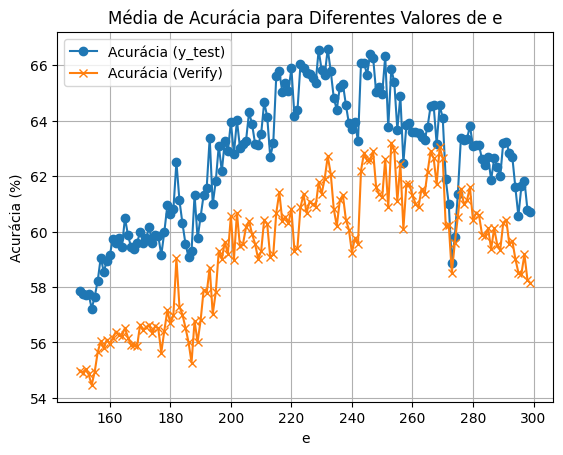

In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import winsound

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por e
mean_accuracy_by_e = []

# Loop para cada e em n_list e realização de validação cruzada em série temporal
for e in e_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{t}',
                    f'r_percent_{t}',
                    f'Price_Rate_Of_Change_{e}',
                    'MACD',
                    'MACD_EMA',
                    'On Balance Volume']]
    y = price_data['Prediction']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse e
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'e: {e}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True,n_jobs=-1)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por e
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_e.append((e, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para e {e}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para e {e}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for e, acc_ytest, acc_verify in mean_accuracy_by_e:
    print(f'e: {e} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por e
import matplotlib.pyplot as plt

e_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_e)

plt.plot(e_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(e_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de e")
plt.xlabel('e')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
winsound.Beep(440, 300)